# MLP

Run on Windows


## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-03 11:56:45.850518
Python 3.10.6
sklearn 1.1.2


In [2]:
import tensorflow as tf
dt = np.float32
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 
#from sklearn.model_selection import ShuffleSplit
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedKFold
#from sklearn.model_selection import StratifiedKFold
#import tensorflow as tf
#from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
#from keras.layers import Bidirectional
from keras.layers import Dense
#from keras.layers import LayerNormalization
#from sklearn.preprocessing import StandardScaler
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=10
FOLDS=5
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'
GENES_FILE = 'CNRCI_coding_train_genes.csv'
RCI_FILE = 'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE='CNRCI_coding_train_counts.K4.gc42.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp       = Sequential()
    one_layer = Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-11-03 11:57:05.287845
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


## Load the data

In [7]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-03 11:57:05.370824
Num RCI: 10338
[('ENSG00000000003', 1.08068), ('ENSG00000000419', 1.32679), ('ENSG00000000457', 0.434284)]


In [8]:
# kmer counts
filepath = DATA_DIR+COUNTS_FILE
labels=[]
allids=[]
counts=[]
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            gene_id = fields.pop(0)
            tran_id = fields.pop(0)
            numbers = [int(x) for x in fields]
            if gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                counts.append(numbers)
print(datetime.now())
print('Num IDs:',len(allids))
print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(counts))
print('Example:',counts[3])

2022-11-03 11:57:07.751165
Num IDs: 54251
Examples: [('ENSG00000187634', 'ENST00000455979.1'), ('ENSG00000187608', 'ENST00000624652.1'), ('ENSG00000131591', 'ENST00000427787.5'), ('ENSG00000160087', 'ENST00000360466.6')]
Num labels: 54251
Examples: [-1.20021, -0.0182098, -1.98467, -0.297418]
Num counts: 54251
Example: [9, 2, 7, 6, 5, 6, 1, 4, 14, 10, 10, 3, 4, 2, 4, 3, 6, 7, 6, 3, 8, 14, 7, 13, 6, 2, 15, 8, 0, 8, 10, 6, 9, 10, 19, 7, 17, 24, 15, 20, 22, 15, 26, 7, 1, 5, 4, 1, 3, 1, 0, 2, 4, 8, 2, 5, 4, 5, 11, 3, 1, 1, 1, 3, 8, 5, 10, 1, 13, 19, 9, 9, 14, 45, 26, 2, 1, 6, 6, 1, 9, 31, 31, 3, 32, 60, 24, 29, 12, 19, 22, 7, 2, 21, 39, 10, 4, 9, 15, 4, 4, 25, 10, 5, 16, 24, 18, 7, 2, 11, 5, 3, 0, 5, 1, 1, 11, 19, 9, 12, 13, 42, 29, 10, 2, 16, 7, 7, 4, 9, 20, 5, 3, 15, 18, 9, 17, 21, 31, 6, 1, 7, 9, 1, 3, 8, 34, 4, 21, 52, 21, 19, 12, 17, 17, 4, 2, 13, 33, 12, 14, 17, 34, 6, 15, 39, 18, 23, 20, 37, 41, 10, 2, 12, 15, 2, 0, 1, 2, 2, 7, 13, 5, 8, 8, 6, 16, 2, 1, 2, 4, 3, 3, 0, 0, 1, 1, 2, 3, 

In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    return subsetX,subsetY

## Train and validate with all K-mer counts

In [10]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,counts,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,counts,labels,0)
        #train_genes,valid_genes = one_partition[0],one_partition[1]
        #thresholdsT = splitter.choose_thresholds(train_genes,'one_z')
        #X_train,y_train,train_ids = splitter.get_X_y(train_genes, thresholdsT)
        #thresholdsV = splitter.choose_thresholds(train_genes,'mean')
        #X_valid,y_valid,valid_ids = splitter.get_X_y(valid_genes, thresholdsV)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    print()
    print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-11-03 11:57:07.803162
2022-11-03 11:57:07.803162
splitting
Fold 1
Train sizes 43592 43592
Valid sizes 10659 10659
Train set ones/size 21682 / 43592
Valid set ones/size 5237 / 10659
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 11:57:07.843211
Epoch 1/10
1363/1363 [==============================] - 9s 6ms/step - loss: 1.2034 - accuracy: 0.5885 - val_loss: 0.8783 - val_accuracy: 0.6244
Epoch 2/10
1363/1363 [==============================] - 2s 1ms/step - loss: 0.7511 - accuracy: 0.6365 - val_loss: 0.6927 - val_accuracy: 0.6624
Epoch 3/10
1363/1363 [==============================] - 1s 1ms/step - loss: 0.6573 - accuracy: 0.6612 - val_loss: 0.7262 - val_accuracy: 0.6569
Epoch 4/10
1363/1363 [==============================] - 1s 1ms/step - loss: 0.6388 - accuracy: 0.6685 - val_loss: 0.7534 - val_accuracy: 0.6485
Epoch 5/10
1363/1363 [==============================] - 1s 1ms/step - loss: 0.6360 - accuracy: 0.6698 - val_loss: 0.7647 - val_accuracy: 0.6442
Epoch 6/10
1363/1363 [======

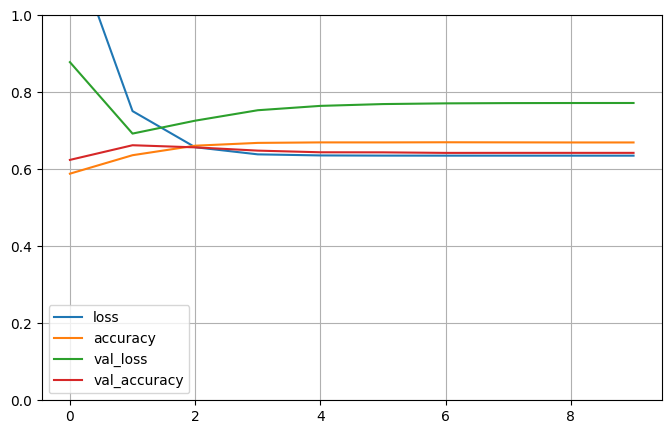

Compute valiation accuracy
2022-11-03 11:57:58.135298
accuracy: 64.26%
2022-11-03 11:58:05.072952
Fold 2
Train sizes 43443 43443
Valid sizes 10808 10808
Train set ones/size 21628 / 43443
Valid set ones/size 5291 / 10808
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 11:58:05.104927
Epoch 1/10
1358/1358 [==============================] - 8s 6ms/step - loss: 1.3552 - accuracy: 0.5863 - val_loss: 0.9654 - val_accuracy: 0.5954
Epoch 2/10
1358/1358 [==============================] - 1s 996us/step - loss: 0.7401 - accuracy: 0.6398 - val_loss: 0.8217 - val_accuracy: 0.6163
Epoch 3/10
1358/1358 [==============================] - 1s 996us/step - loss: 0.6497 - accuracy: 0.6655 - val_loss: 0.9808 - val_accuracy: 0.5844
Epoch 4/10
1358/1358 [==============================] - 1s 990us/step - loss: 0.6400 - accuracy: 0.6712 - val_loss: 0.9873 - val_accuracy: 0.5828
Epoch 5/10
1358/1358 [==============================] - 1s 1ms/step - loss: 0.6390 - accuracy: 0.6722 - val_loss: 0.9895 - val_accur

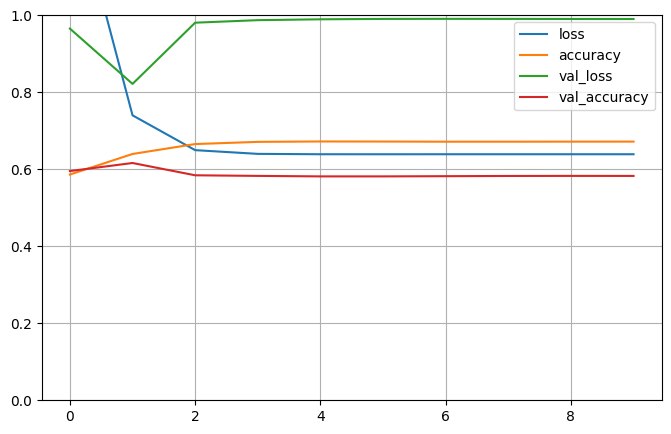

Compute valiation accuracy
2022-11-03 11:58:53.442903
accuracy: 58.27%
2022-11-03 11:59:00.544009
Fold 3
Train sizes 43240 43240
Valid sizes 11011 11011
Train set ones/size 21736 / 43240
Valid set ones/size 5183 / 11011
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 11:59:00.580004
Epoch 1/10
1352/1352 [==============================] - 9s 6ms/step - loss: 1.4895 - accuracy: 0.5921 - val_loss: 1.0303 - val_accuracy: 0.5878
Epoch 2/10
1352/1352 [==============================] - 1s 989us/step - loss: 0.7754 - accuracy: 0.6387 - val_loss: 0.7396 - val_accuracy: 0.6127
Epoch 3/10
1352/1352 [==============================] - 1s 981us/step - loss: 0.6631 - accuracy: 0.6622 - val_loss: 0.6784 - val_accuracy: 0.6259
Epoch 4/10
1352/1352 [==============================] - 1s 982us/step - loss: 0.6471 - accuracy: 0.6694 - val_loss: 0.6596 - val_accuracy: 0.6340
Epoch 5/10
1352/1352 [==============================] - 1s 987us/step - loss: 0.6455 - accuracy: 0.6695 - val_loss: 0.6551 - val_acc

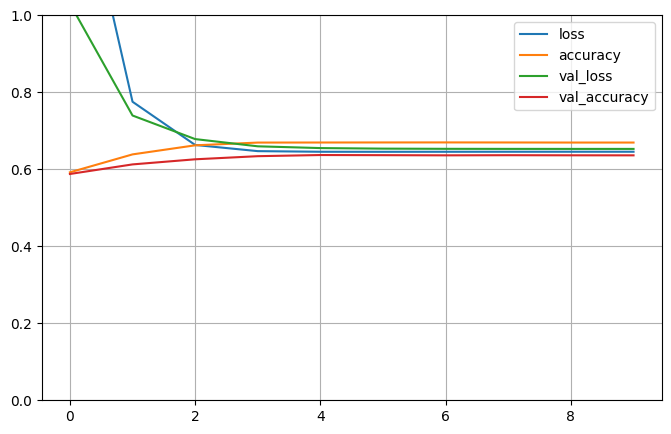

Compute valiation accuracy
2022-11-03 11:59:48.449948
accuracy: 63.62%
2022-11-03 11:59:55.551582
Fold 4
Train sizes 43345 43345
Valid sizes 10906 10906
Train set ones/size 21265 / 43345
Valid set ones/size 5654 / 10906
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 11:59:55.587562
Epoch 1/10
1355/1355 [==============================] - 9s 6ms/step - loss: 1.2822 - accuracy: 0.5955 - val_loss: 0.9229 - val_accuracy: 0.5928
Epoch 2/10
1355/1355 [==============================] - 1s 990us/step - loss: 0.7756 - accuracy: 0.6368 - val_loss: 0.7836 - val_accuracy: 0.6035
Epoch 3/10
1355/1355 [==============================] - 1s 1ms/step - loss: 0.6587 - accuracy: 0.6611 - val_loss: 0.7194 - val_accuracy: 0.6164
Epoch 4/10
1355/1355 [==============================] - 1s 1ms/step - loss: 0.6421 - accuracy: 0.6659 - val_loss: 0.6726 - val_accuracy: 0.6321
Epoch 5/10
1355/1355 [==============================] - 1s 993us/step - loss: 0.6394 - accuracy: 0.6658 - val_loss: 0.6601 - val_accurac

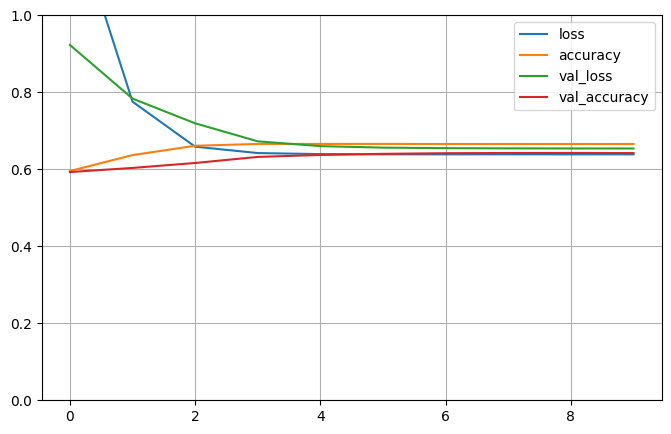

Compute valiation accuracy
2022-11-03 12:00:43.636435
accuracy: 64.21%
2022-11-03 12:00:50.707555
Fold 5
Train sizes 43384 43384
Valid sizes 10867 10867
Train set ones/size 21365 / 43384
Valid set ones/size 5554 / 10867
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 12:00:50.739523
Epoch 1/10
1356/1356 [==============================] - 9s 7ms/step - loss: 1.2862 - accuracy: 0.5952 - val_loss: 0.8696 - val_accuracy: 0.6092
Epoch 2/10
1356/1356 [==============================] - 1s 1ms/step - loss: 0.7711 - accuracy: 0.6378 - val_loss: 0.6586 - val_accuracy: 0.6707
Epoch 3/10
1356/1356 [==============================] - 2s 1ms/step - loss: 0.6503 - accuracy: 0.6624 - val_loss: 0.6270 - val_accuracy: 0.6817
Epoch 4/10
1356/1356 [==============================] - 1s 1ms/step - loss: 0.6357 - accuracy: 0.6677 - val_loss: 0.6239 - val_accuracy: 0.6775
Epoch 5/10
1356/1356 [==============================] - 1s 1ms/step - loss: 0.6345 - accuracy: 0.6686 - val_loss: 0.6240 - val_accuracy: 0

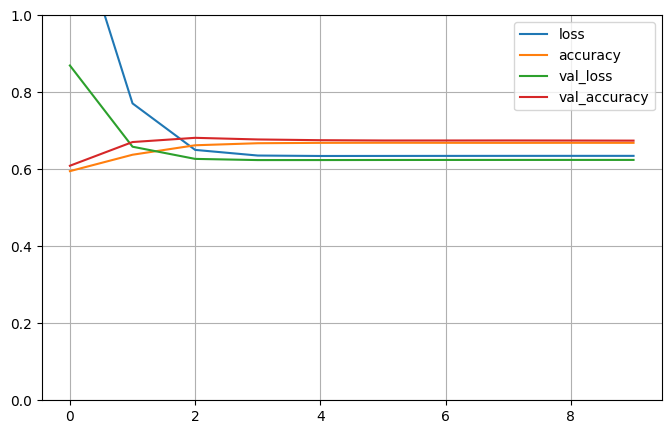

Compute valiation accuracy
2022-11-03 12:01:41.715413
accuracy: 67.44%
2022-11-03 12:01:49.820843

Cross validation acc mean 63.56% (+/- 2.97%)
2022-11-03 12:01:49.820843


In [11]:
print(datetime.now())
do_cross_validation(EPOCHS)    
print(datetime.now())